# Analalyse de la distribution du vocabulaire

## Imports et dépendances

### Nettoyage avec spacy

In [17]:
import os
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import Counter
import matplotlib.pyplot as plt

# Télécharger les stopwords si besoin
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
# --- CHARGEMENT DU CORPUS ---
path = "../../data/clean_corpus.txt"
with open(path, "r", encoding="utf-8") as f:
    full_text = f.read().strip()  # .strip() pour supprimer espaces initiaux/finaux

print(f"Corpus chargé : {len(full_text):,} caractères ({len(full_text)/10**6:.2f} Mo)")

Corpus chargé : 11,050,562 caractères (11.05 Mo)


## Créer une une liste de stopwords

In [58]:
# Stopwords standard + personnalisés
sw = set(stopwords.words("french"))
custom_stopwords = [
    "article", "journal", "reportage", "kb", "texte", "page", "numéro",
    "fait", "faire", "avoir", "être", "dire", "ainsi", "ils", "elle",
    "cela", "cet", "cette", "leurs", "tout", "tous", "aussi", "non",
]
sw |= set(custom_stopwords)
print(f"{len(sw)} stopwords chargés.")


178 stopwords chargés.


In [59]:
print(f"{len(sw)} stopwords:\n {sorted(sw)}")

178 stopwords:
 ['ai', 'aie', 'aient', 'aies', 'ainsi', 'ait', 'article', 'as', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayante', 'ayantes', 'ayants', 'ayez', 'ayons', 'c', 'ce', 'cela', 'ces', 'cet', 'cette', 'd', 'dans', 'de', 'des', 'dire', 'du', 'elle', 'en', 'es', 'est', 'et', 'eu', 'eue', 'eues', 'eurent', 'eus', 'eusse', 'eussent', 'eusses', 'eussiez', 'eussions', 'eut', 'eux', 'eûmes', 'eût', 'eûtes', 'faire', 'fait', 'furent', 'fus', 'fusse', 'fussent', 'fusses', 'fussiez', 'fussions', 'fut', 'fûmes', 'fût', 'fûtes', 'il', 'ils', 'j', 'je', 'journal', 'kb', 'l', 'la', 'le', 'les', 'leur', 'leurs', 'lui', 'm', 'ma', 'mais', 'me', 'mes', 'moi', 'mon', 'même', 'n', 'ne', 'non', 'nos', 'notre', 'nous', 'numéro', 'on', 'ont', 'ou', 'page', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'reportage', 's', 'sa',

## Nettoyage simple

In [60]:
# Supprimer métadonnées, ponctuation et espaces multiples
def clean_text(text):
    text = re.sub(r'###.*?###', ' ', text)          # Supprime métadonnées (ex: ### KB_123 ###)
    text = re.sub(r'[^\w\s\'\-]', '', text)         # conserve apostrophes (') et tirets (-)
    text = re.sub(r'\s+', ' ', text).strip().lower() # Normalise espaces + minuscules
    return text

full_text = clean_text(full_text)


## Tokeniser

In [62]:
print("\n--- Tokenisation ---")
tokens = wordpunct_tokenize(full_text)

# Filtrage progressif
tokens = [
    t for t in tokens
    if t.isalpha() and len(t) > 2 and t not in sw
]
print(f"{len(tokens):,} tokens après filtrage initial.")


--- Tokenisation ---
972,745 tokens après filtrage initial.


In [63]:
print("\n--- Lemmatisation ---")
# Lemmatisation avec spaCy
nlp = spacy.load("fr_core_news_lg", disable=["ner", "parser", "attribute_ruler", "tok2vec"])
nlp.max_length = len(full_text) + 1000


--- Lemmatisation ---


In [64]:
# Traitement par lots pour éviter les crashes mémoire
batch_size = 10000
lemmas = []

In [65]:
for i in range(0, len(tokens), batch_size):
    batch = tokens[i:i + batch_size]
    doc = nlp(" ".join(batch))
    lemmas.extend(
        token.lemma_.lower()
        for token in doc
        if token.lemma_.isalpha() and len(token.lemma_) > 2
    )

print(f"{len(lemmas):,} lemmes générés.")

970,215 lemmes générés.


## FILTRAGE DYNAMIQUE DES STOPWORDS

In [66]:
print("\n--- Filtrage dynamique ---")
freq = Counter(lemmas)
extra_stopwords = {w for w, _ in freq.most_common(800)}

# Conservation des noms propres importants
important_words = {"bruxelles", "paris", "belgique", "europe"}  # À adapter
extra_stopwords -= important_words  # Retire ces mots des stopwords

sw.update(extra_stopwords)
lemmas = [l for l in lemmas if l not in sw and len(l) > 2]

print(f"{len(lemmas):,} lemmes après filtrage dynamique.")


--- Filtrage dynamique ---
567,229 lemmes après filtrage dynamique.


### regarder mieux les premieer lignes ici: 


--- Analyse de fréquence finale ---
20 mots les plus fréquents : [('bruxelles', 2197), ('belgique', 956), ('europe', 221), ('prétendre', 207), ('italie', 207), ('étage', 207), ('malade', 207), ('enseignement', 206), ('piano', 206), ('populaire', 206), ('café', 206), ('pareil', 206), ('kilo', 205), ('new', 205), ('excellent', 205), ('parfois', 205), ('travailleur', 204), ('instant', 204), ('conclure', 204), ('troisième', 203)]


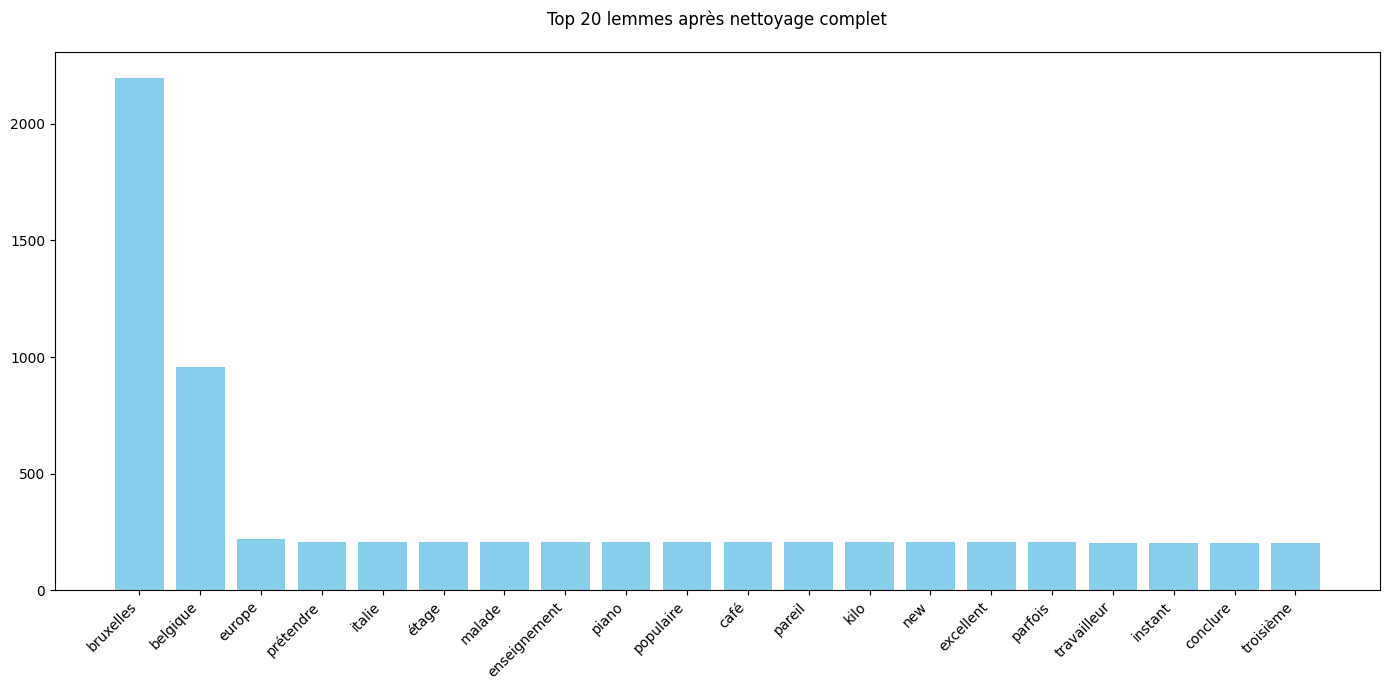

In [67]:
#analyse de fréquence finale
print("\n--- Analyse de fréquence finale ---")

if lemmas:
    freq = Counter(lemmas)
    most_common = freq.most_common(20)
    print("20 mots les plus fréquents :", most_common)

    words, counts = zip(*most_common)
    plt.figure(figsize=(14, 7))
    plt.bar(words, counts, color="skyblue")
    plt.xticks(rotation=45, ha="right")
    plt.title("Top 20 lemmes après nettoyage complet", pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("Aucun mot à afficher.")


In [68]:
words[:10]

('bruxelles',
 'belgique',
 'europe',
 'prétendre',
 'italie',
 'étage',
 'malade',
 'enseignement',
 'piano',
 'populaire')

## Calculer la taille du vocabulaire

In [69]:
print("\n--- Vocabulaire ---")
voc = set(lemmas)
print(f"{len(voc):,} mots uniques dans le vocabulaire.")


--- Vocabulaire ---
128,773 mots uniques dans le vocabulaire.


## Récupérer les mots les plus fréquents et en faire un plot

In [70]:
fdist = nltk.FreqDist(kept)
fdist.most_common(10)

[('plus', 1),
 ('pouvoir', 1),
 ('rue', 1),
 ('cest', 1),
 ('quil', 1),
 ('dun', 1),
 ('grand', 1),
 ('comme', 1),
 ('deux', 1),
 ('dune', 1)]

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

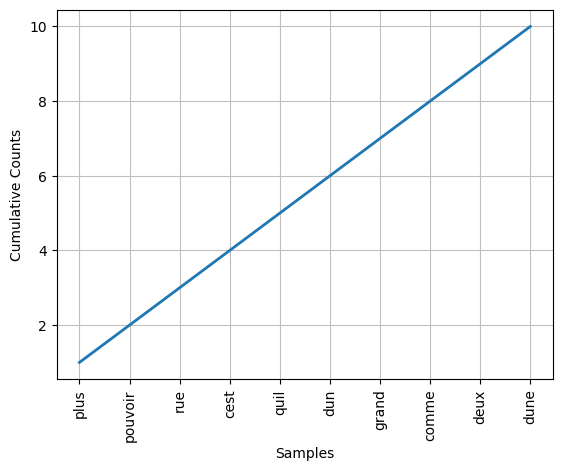

In [71]:
# Plot: les n mots les plus fréquents
n = 10
fdist.plot(n, cumulative=True)

## Détecter les Hapax (mots qui n'apparaissent qu'une fois dans le corpus)

In [72]:
print("\n--- Hapax (mots uniques) ---")
hapaxes = [
    lemma for lemma, count in freq.items()
    if count == 1
    and not re.search(r'(.)\1{3,}', lemma)  # Filtrage des répétitions (ex: "aaaaa")
    and len(lemma) < 20  #  Exclusion des mots trop longs
    and lemma.isalpha()  #  Uniquement alphabétique
]
print(f"{len(hapaxes):,} hapaxes valides (après filtrage) :")
print(hapaxes[:30])


--- Hapax (mots uniques) ---
93,915 hapaxes valides (après filtrage) :
['eotîge', 'tribunh', 'scîopero', 'zona', 'oarbonifera', 'boribage', 'hanmo', 'avuto', 'luogo', 'ponenti', 'dove', 'quesbe', 'gtandi', 'addi', 'mostrato', 'spirito', 'monito', 'tracotanza', 'padronale', 'ruonatori', 'gfànizzanô', 'manifestaziane', 'disra', 'rosea', 'avvia', 'quiaregnon', 'moltitudino', 'faociei', 'segni', 'caratterisitici']


## Trouver les mots les plus longs du corpus

In [73]:
print("\n--- Mots les plus longs ---")
long_words = sorted(
    (w for w in voc
     if len(w) > 10
     and not re.search(r'(.)\1{3,}', w)  #  Exclut les répétitions
     and w.isalpha()),  # Uniquement alphabétique
    key=lambda x: (-len(x), x)  # Trie par longueur décroissante
)[:30]

print("30 mots les plus longs (filtrés) :")
for i, word in enumerate(long_words, 1):
    print(f"{i:2d}. {word} ({len(word)} lettres)")


--- Mots les plus longs ---
30 mots les plus longs (filtrés) :
 1. xiiixiiikiiixiiixiiixxiiixiiixiiixiiixiiix (42 lettres)
 2. wiikiiimiixiiixiiixwiixilimiixlilxiiix (38 lettres)
 3. auiétantsquicaraclérisentlesdernières (37 lettres)
 4. naudquiparaissaitsouslestraitsdupèred (37 lettres)
 5. enleveroettenuitdonalsabeldeguzmau (34 lettres)
 6. intelliqetitsupêrieuretnentqouvemg (34 lettres)
 7. jijjqflruillsecrlrijnpieiijenload (33 lettres)
 8. lioveinenreinpiaiementdifsonpéroi (33 lettres)
 9. siîcwugsikoulobiaviialijiefinosss (33 lettres)
10. cobpàgsiedesbrqnzesdépôtgénird (30 lettres)
11. zxhtocfctirrmœsfiourdupncaleam (30 lettres)
12. fbabbgbbmmbctyjpsébjbjpebgblb (29 lettres)
13. kigiâiisisbbbiiaiigéiibassiii (29 lettres)
14. lesépanouisbementsvertspourla (29 lettres)
15. extraordinairecomplicaftioni (28 lettres)
16. vuvjvjvsjjvjvvjvuufjvvjvvwvv (28 lettres)
17. éviterdenonveauxconflitsdece (28 lettres)
18. lapveflesminenrsfluboribage (27 lettres)
19. peurdesamaturitérudemariene (

### EXPORT DES RÉSULTATS 

In [74]:
print("\n--- Export des résultats ---")
output_dir = "../../data/results"
os.makedirs(output_dir, exist_ok=True)

#  Sauvegarde des données clés
with open(f"{output_dir}/lemmes_final.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(lemmas))
print(f"Lemmes sauvegardés dans {output_dir}/lemmes_final.txt")

with open(f"{output_dir}/hapaxes.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(hapaxes))
print(f"Hapax sauvegardés dans {output_dir}/hapaxes.txt")

with open(f"{output_dir}/long_words.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(long_words))
print(f"Mots longs sauvegardés dans {output_dir}/long_words.txt")


--- Export des résultats ---
Lemmes sauvegardés dans ../../data/results/lemmes_final.txt
Hapax sauvegardés dans ../../data/results/hapaxes.txt
Mots longs sauvegardés dans ../../data/results/long_words.txt
